In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from typing import Dict, List

# Configurar a semente aleatória para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Parte 1: Preparação dos dados

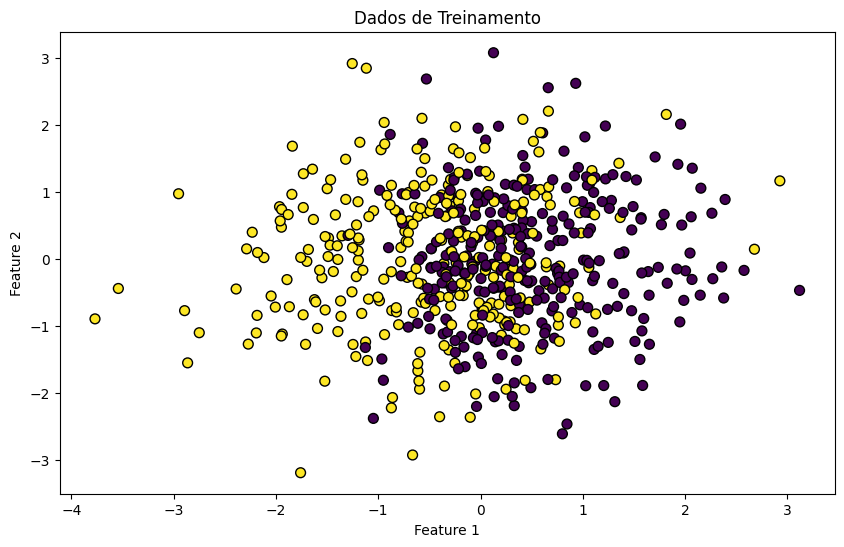

In [2]:
#####################################
# Parte 1: Preparação dos Dados
#####################################

# Criar um dataset sintético para classificação
# make_classification gera um conjunto de dados para classificação binária
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# First split: 80% train+val, 20% test (for final evaluation)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: 75% train, 25% val (of the remaining 80% = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# Normalizar os dados
# A normalização é importante para o treinamento eficiente de redes neurais
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Converter para tensores PyTorch
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title("Dados de Treinamento")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Parte 2: Definição da Rede Neural

In [3]:
#####################################
# Parte 2: Definição da Rede Neural
#####################################

# Definir a classe da rede neural
class ClassificationNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, act_fun=nn.ReLU(), dropout_rate=0.0):
        """
        Inicializa a arquitetura da rede neural para classificação.
        
        Parâmetros:
        input_size (int): Número de features de entrada
        hidden_size (list): Lista de número de neurônios em cada camada oculta
        output_size (int): Número de classes (2 para classificação binária)
        act_fun (nn.Module ou list): Função(ões) de ativação para usar. Pode ser:
            - Uma única ativação aplicada à todas as camadas
            - Uma lista de ativações para cada camada escondida
        """
        super(ClassificationNet, self).__init__()
        
        # Validate and process activation functions
        if isinstance(act_fun, list):
            if len(act_fun) != len(hidden_sizes):
                raise ValueError("act_fun list must match hidden_sizes length")
        else:
            act_fun = [act_fun for _ in hidden_sizes]
            
        # Validate and process dropout rates
        if isinstance(dropout_rate, list):
            if len(dropout_rate) != len(hidden_sizes):
                raise ValueError("dropout_rate list must match hidden_sizes length")
        else:
            dropout_rate = [dropout_rate for _ in hidden_sizes]
        
        layers = []
        in_features = input_size
        
        # Build hidden layers
        for i, (h_size, activation, drop_rate) in enumerate(zip(
            hidden_sizes, act_fun, dropout_rate)):
            
            # Linear layer
            layers.append(nn.Linear(in_features, h_size))
            
            # Activation
            layers.append(activation)
            
            # Dropout (except after last hidden layer)
            if i < len(hidden_sizes) - 1 and drop_rate > 0:
                layers.append(nn.Dropout(drop_rate))
            
            in_features = h_size
        
        # Output layer (no activation or dropout)
        layers.append(nn.Linear(in_features, output_size))
        
        # Combine all layers into a sequential model
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Define the forward pass through the network.
        
        Parameters:
        x (Tensor): Input tensor
        
        Returns:
        Tensor: Output of the neural network
        """
        return self.net(x)

# Parte 3: Treinamento do Modelo

In [24]:
def load_model(path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(path, map_location=device)
    config = checkpoint['config']
    
    act_fun = getattr(torch.nn, config['act_fun'])()  # Convert string to class
    
    model = ClassificationNet(
        input_size=config['input_size'],
        hidden_sizes=config['hidden_sizes'],
        output_size=config['output_size'],
        act_fun=act_fun,
        dropout_rate=config['dropout_rate'],
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [25]:
#####################################
# Parte 3: Treinamento do Modelo
#####################################

def train_model(
    x_train, y_train,
    x_val=None, y_val=None,
    input_size=None,
    hidden_sizes=[50, 30],
    output_size=2,
    optimizer_class=torch.optim.Adam,
    learning_rate=0.001,
    batch_size=None,  # If None: full-batch training (legacy mode)
    num_epochs=100,
    act_fun=torch.nn.ReLU(),
    dropout_rate=0.0,
    patience=5,
    min_delta=0.001,
    verbose=False,
    **dataloader_kwargs
):

    # --- Convert data to DataLoaders ONLY if batch_size is provided ---
    def _to_dataloader(features, labels, shuffle):
        if batch_size is None:  # Legacy mode (return raw tensors)
            features = torch.FloatTensor(features) if not isinstance(features, torch.Tensor) else features.float()
            labels = torch.LongTensor(labels) if not isinstance(labels, torch.Tensor) else labels.long()
            return features, labels
        else:  # Mini-batch mode
            dataset = DatasetWrapper(features, labels)
            return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, **dataloader_kwargs)

    class DatasetWrapper(Dataset):
        """Minimal wrapper to convert raw data to a PyTorch Dataset."""
        def __init__(self, features, labels):
            self.features = torch.FloatTensor(features) if not isinstance(features, torch.Tensor) else features.float()
            self.labels = torch.LongTensor(labels) if not isinstance(labels, torch.Tensor) else labels.long()
        def __len__(self):
            return len(self.features)
        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
    
    output_size = len(torch.unique(y_train))  # Automatically detect

    # Prepare data loaders or raw tensors
    train_data = _to_dataloader(x_train, y_train, shuffle=True)
    val_data = _to_dataloader(x_val, y_val, shuffle=False) if x_val is not None else None

    # --- Model setup ---
    input_dim = input_size if input_size else (
        train_data.dataset.features.shape[1] if batch_size else train_data.shape[1]
    )
    model = ClassificationNet(
        input_size=input_dim,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        act_fun=act_fun,
        dropout_rate=dropout_rate
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # --- Training loop ---
    train_losses, val_losses, val_accs = [], [], []
    best_val_loss = float('inf')
    best_val_acc = float('-inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- Training phase ---
        model.train()
        total_correct = 0
        
        if batch_size:  # Mini-batch mode
            epoch_train_loss = 0.0
            for batch_x, batch_y in train_data:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * batch_x.size(0)
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == batch_y).sum().item()
            train_loss = epoch_train_loss / len(train_data.dataset)
            # train_acc = total_correct / len(train_data.dataset)
        else:  # Full-batch mode
            optimizer.zero_grad()
            outputs = model(train_data[0])  # train_data is (features, labels)
            loss = criterion(outputs, train_data[1])
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            _, preds = torch.max(outputs, 1)
            # train_acc = (preds == train_data[1]).sum().item() / len(train_data.dataset)
        train_losses.append(train_loss)

        # --- Validation phase ---
        if val_data is not None:
            model.eval()
            with torch.no_grad():
                if batch_size:  # Mini-batch validation
                    epoch_val_loss = 0.0
                    val_acc = 0
                    for batch_x, batch_y in val_data:
                        outputs = model(batch_x)
                        epoch_val_loss += criterion(outputs, batch_y).item() * batch_x.size(0)
                        _, preds = torch.max(outputs, 1)
                        val_acc += (preds == batch_y).float().mean()
                    val_loss = epoch_val_loss / len(val_data.dataset)
                    val_acc = val_acc / len(val_data.dataset)
                else:  # Full-batch validation
                    outputs = model(val_data[0])
                    val_loss = criterion(outputs, val_data[1]).item()
                    _, preds = torch.max(outputs, 1)
                    val_acc = (preds == val_data[1]).float().mean()
            val_accs.append(val_acc)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss - min_delta or val_acc > best_val_acc:
                epochs_no_improve = 0
                best_val_acc = val_acc
                best_val_loss = val_loss
                best_model_weights = model.state_dict().copy()
                
                # Save (always move to CPU first)
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'config': {
                        'input_size': input_size,
                        'hidden_sizes': hidden_sizes,
                        'output_size': output_size,
                        'act_fun': type(act_fun).__name__,
                        'dropout_rate': dropout_rate,
                    }
                }, 'model.pth')
            elif val_loss >= best_val_loss:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    break

        # Logging
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            log_msg = f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}"
            if val_data is not None:
                log_msg += f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            print(log_msg)

    # Load best model if early stopping was triggered
    if val_data is not None and 'best_model_weights' in locals():
        # model.load_state_dict(best_model_weights)
        model = load_model('model.pth')

    return model, train_losses, val_losses if val_data is not None else None

In [6]:
def evaluate_model(model, x, y):
    # Definir o modelo para modo de avaliação
    model.eval()

    # Desabilitar o cálculo de gradientes para avaliação
    with torch.no_grad():
        # Fazer previsões no conjunto de teste
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        
        # Calcular a acurácia
        accuracy = (predicted == y).sum().item() / y.size(0)
        # print(f'Acurácia no conjunto de teste: {accuracy:.4f}')
    
    return predicted, accuracy


In [7]:
def plot_loss(train_losses):
    # Plotar a curva de perda
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Curva de Perda - Classificação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.grid(True)
    plt.show()


def plot_confusion_mat(y, predicted):
    # Plotar a matriz de confusão
    cm = confusion_matrix(y, predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.xticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
    plt.show()


# Parte 4: Avaliação do Modelo

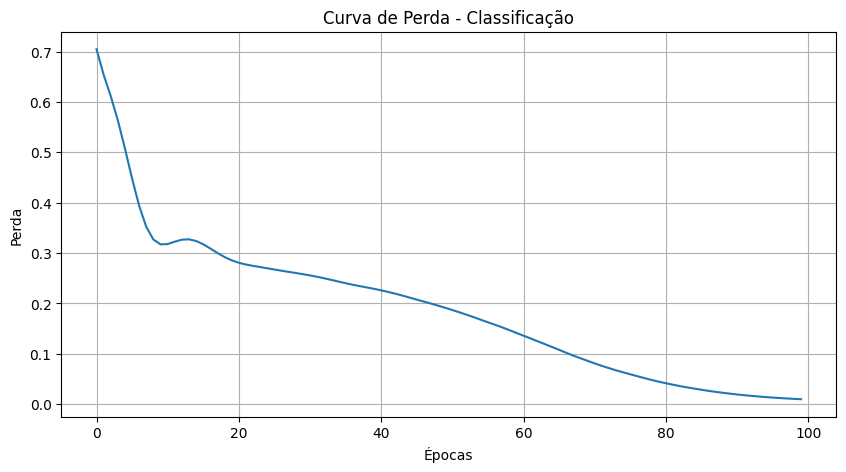

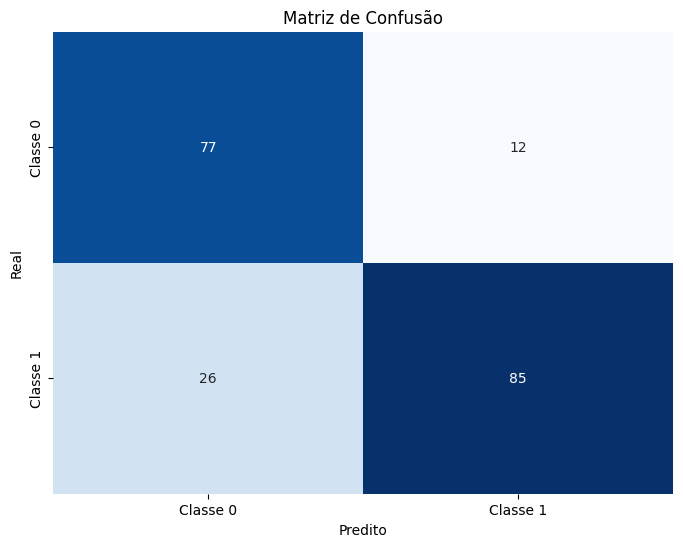

In [8]:
#####################################
# Parte 4: Avaliação do Modelo
#####################################

# Hiperparâmetros
input_size = 10  # Número de features de entrada
hidden_size1 = 32  # Tamanho da primeira camada oculta
hidden_size2 = 16  # Tamanho da segunda camada oculta
output_size = 2  # Duas classes para classificação binária
learning_rate = 0.01  # Taxa de aprendizado
num_epochs = 100  # Número de épocas de treinamento

model, train_losses, _ = train_model(X_train_tensor, y_train_tensor,
                                  input_size=input_size,
                                  hidden_size=[hidden_size1, hidden_size2],
                                  output_size=output_size,
                                  learning_rate=learning_rate,
                                  num_epochs=num_epochs)
predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

plot_loss(train_losses)
plot_confusion_mat(y_test_tensor, predicted)


# TODO

1. Tente modificar a arquitetura da rede adicionando mais camadas ocultas.
2. Experimente diferentes funções de ativação (Sigmoid, Tanh, LeakyReLU).
3. Adicione técnicas de regularização como Dropout para evitar overfitting.
4. Implemente a técnica de early stopping para interromper o treinamento quando não houver melhora.
5. Experimente diferentes otimizadores (SGD, RMSprop).
6. Tente criar um problema de classificação multiclasse (mais de 2 classes).
7. Use o DataLoader do PyTorch para treinar com mini-batches.
8. Visualize os pesos da rede após o treinamento.
9. Implemente validação cruzada para avaliar melhor o desempenho do modelo.
10. Salve e carregue o modelo treinado usando torch.save() e torch.load().
11. Otimize o modelo usando o Optuna

# 1. Modificando a arquitetura: mais camadas ocultas

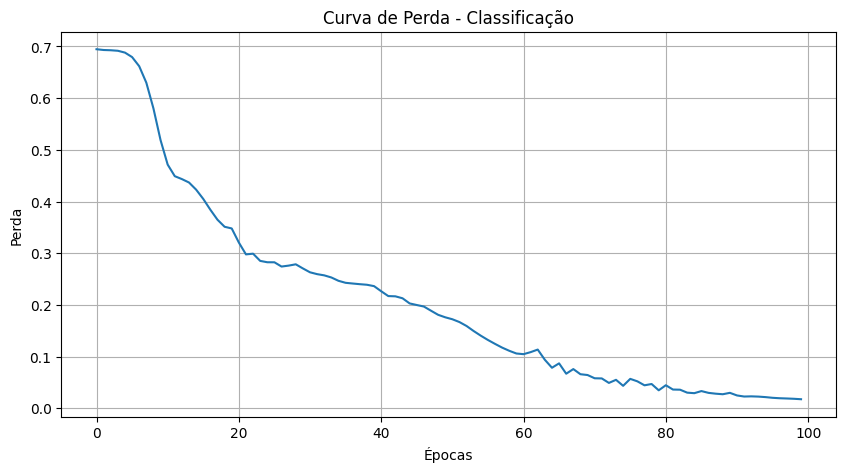

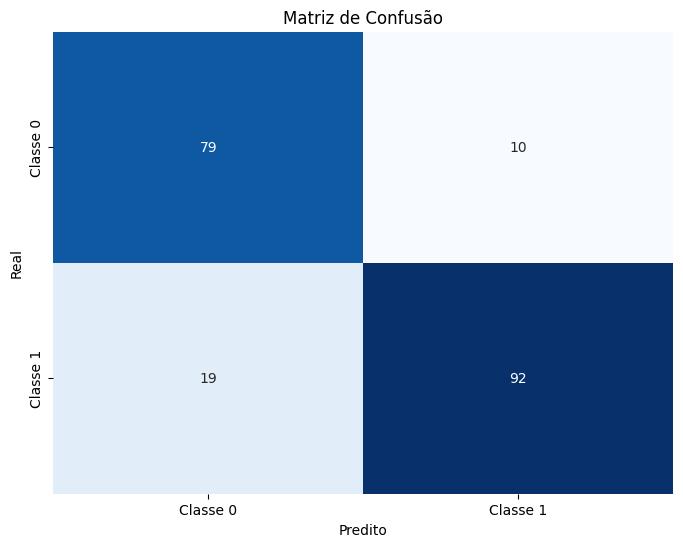

In [9]:
model, train_losses, _ = train_model(X_train_tensor, y_train_tensor,
                                  input_size=input_size,
                                  hidden_sizes=[64, 48, 32, 24, 16, 12, 8],
                                  output_size=output_size,
                                  learning_rate=learning_rate,
                                  num_epochs=100)
predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

plot_loss(train_losses)
plot_confusion_mat(y_test_tensor, predicted)

# 2. Diferentes funções de ativação

In [10]:
n = 50
for act_fun in [nn.ReLU(), nn.LeakyReLU(negative_slope=0.1), nn.GELU(), nn.ELU(), nn.Tanh(), nn.Sigmoid()]:
    accuracies = np.zeros(n)
    for j in range(n):
        model, train_losses, _ = train_model(X_train_tensor, y_train_tensor,
                                        input_size=input_size,
                                        hidden_sizes=[48, 32, 24, 16, 12, 8, 4],
                                        output_size=output_size,
                                        learning_rate=learning_rate,
                                        num_epochs=num_epochs,
                                        act_fun=act_fun)
        predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
        accuracies[j] = accuracy
    
    print(f'{act_fun}: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')
    # plot_loss(train_losses)
    # plot_confusion_mat(y_test_tensor, predicted)

ReLU(): 0.790 +- 0.117
LeakyReLU(negative_slope=0.1): 0.835 +- 0.015
GELU(approximate='none'): 0.831 +- 0.016
ELU(alpha=1.0): 0.848 +- 0.021
Tanh(): 0.838 +- 0.010
Sigmoid(): 0.810 +- 0.108


# 3. Dropout

In [11]:
n = 50
for d in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    accuracies = np.zeros(n)
    for j in range(n):
        model, train_losses, _ = train_model(X_train_tensor, y_train_tensor,
                                        input_size=input_size,
                                        hidden_sizes=[48, 32, 24, 16, 12, 8, 4],
                                        output_size=output_size,
                                        learning_rate=learning_rate,
                                        num_epochs=num_epochs,
                                        act_fun=nn.ELU(),
                                        dropout_rate=d)
        predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
        accuracies[j] = accuracy
    
    print(f'Dropout = {d} -> Accuracy: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')

Dropout = 0.0 -> Accuracy: 0.848 +- 0.022
Dropout = 0.1 -> Accuracy: 0.858 +- 0.021
Dropout = 0.2 -> Accuracy: 0.845 +- 0.012
Dropout = 0.3 -> Accuracy: 0.837 +- 0.007
Dropout = 0.4 -> Accuracy: 0.839 +- 0.006
Dropout = 0.5 -> Accuracy: 0.843 +- 0.006


# 4. Early stopping

In [26]:
n = 50
for patience in [5, 10, 20]:
    accuracies = np.zeros(n)
    for j in range(n):
        model, train_losses, val_losses = train_model(x_train=X_train_tensor, y_train=y_train_tensor,
                                          x_val=X_val_tensor, y_val=y_val_tensor,
                                        input_size=input_size,
                                        hidden_sizes=[48, 32, 24, 16, 12, 8, 4],
                                        output_size=output_size,
                                        learning_rate=learning_rate,
                                        num_epochs=num_epochs,
                                        act_fun=nn.ELU(),
                                        dropout_rate=0.1,
                                        patience=patience)
        predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
        accuracies[j] = accuracy
    
    print(f'Patience = {patience} -> Accuracy: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')

Patience = 5 -> Accuracy: 0.834 +- 0.008
Patience = 10 -> Accuracy: 0.836 +- 0.010
Patience = 20 -> Accuracy: 0.844 +- 0.015


# 5. Diferentes otimizadores

In [28]:
n = 50
for optimizer in [optim.Adam, optim.SGD, optim.Adagrad, optim.Adadelta, optim.Adamax, optim.RMSprop, optim.RAdam, optim.NAdam]:
    accuracies = np.zeros(n)
    for j in range(n):
        model, train_losses, val_losses = train_model(X_train_tensor, y_train_tensor,
                                          X_val_tensor, y_val_tensor,
                                        input_size=input_size,
                                        hidden_sizes=[48, 32, 24, 16, 12, 8, 4],
                                        output_size=output_size,
                                        learning_rate=learning_rate,
                                        optimizer_class=optimizer,
                                        num_epochs=num_epochs,
                                        act_fun=nn.ELU(),
                                        dropout_rate=0.1,
                                        patience=10)
        predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
        accuracies[j] = accuracy
    
    print(f'Optimizer = {optimizer.__name__} -> Accuracy: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')

Optimizer = Adam -> Accuracy: 0.839 +- 0.010
Optimizer = SGD -> Accuracy: 0.484 +- 0.057
Optimizer = Adagrad -> Accuracy: 0.835 +- 0.007
Optimizer = Adadelta -> Accuracy: 0.507 +- 0.067
Optimizer = Adamax -> Accuracy: 0.836 +- 0.008
Optimizer = RMSprop -> Accuracy: 0.847 +- 0.019
Optimizer = RAdam -> Accuracy: 0.834 +- 0.008
Optimizer = NAdam -> Accuracy: 0.841 +- 0.012


# 6. Problema de classificação multiclasse

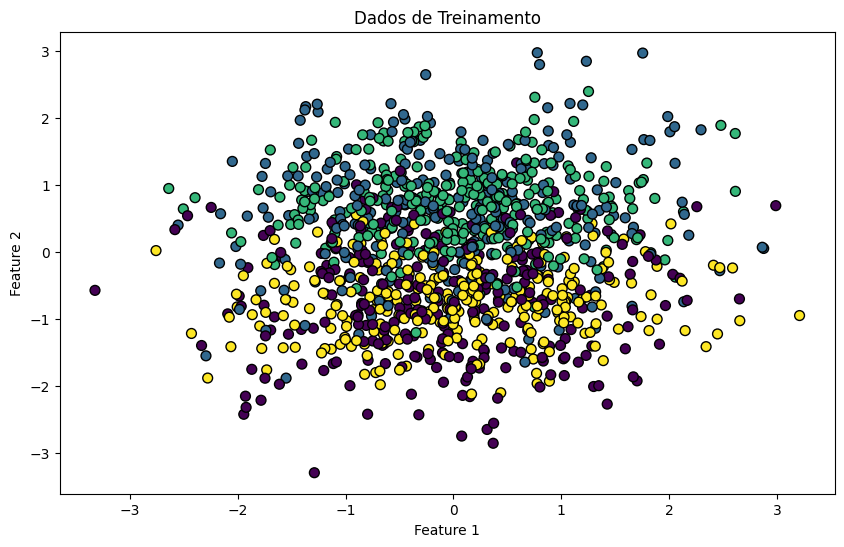

In [29]:
# Criar um dataset sintético para classificação
# make_classification gera um conjunto de dados para classificação binária
X, y = make_classification(
    n_samples=2000,
    n_features=12,
    n_classes=4,
    n_informative=4,  # At least log2(n_classes)
    n_redundant=2,    # Some redundant features
    n_clusters_per_class=1,
    random_state=42
)

# First split: 80% train+val, 20% test (for final evaluation)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: 75% train, 25% val (of the remaining 80% = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# Normalizar os dados
# A normalização é importante para o treinamento eficiente de redes neurais
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Converter para tensores PyTorch
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title("Dados de Treinamento")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [31]:
input_size = 12  # Número de features de entrada
hidden_sizes = [48, 32, 24, 16, 12, 8, 4]
output_size = 4  # Quatro classes para classificação
learning_rate = 0.01  # Taxa de aprendizado
num_epochs = 150  # Número de épocas de treinamento

In [32]:
n = 50
accuracies = np.zeros(n)
for j in range(n):
    model, train_losses, val_losses = train_model(X_train_tensor, y_train_tensor,
                                      X_val_tensor, y_val_tensor,
                                    input_size=input_size,
                                    hidden_sizes=hidden_sizes,
                                    output_size=output_size,
                                    learning_rate=learning_rate,
                                    num_epochs=num_epochs,
                                    act_fun=nn.ELU(),
                                    dropout_rate=0.1,
                                    patience=10)
    predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
    accuracies[j] = accuracy
print(f'Accuracy: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')

Accuracy: 0.887 +- 0.006


# 7. DataLoader do PyTorch para treinar com mini-batches

In [33]:
n = 50
for batch_size in [16, 32, 64, 128]:
  accuracies = np.zeros(n)
  for i in range(n):
      model, train_losses, val_losses = train_model(X_train_tensor, y_train_tensor,
                                        X_val_tensor, y_val_tensor,
                                      input_size=input_size,
                                      hidden_sizes=hidden_sizes,
                                      output_size=output_size,
                                      learning_rate=learning_rate,
                                      batch_size=batch_size,
                                      num_epochs=num_epochs,
                                      act_fun=nn.ELU(),
                                      dropout_rate=0.1,
                                      patience=10)
      predicted, accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
      accuracies[j] = accuracy
  print(f'Batch size {batch_size} --> Accuracy: {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}')

Batch size 16 --> Accuracy: 0.018 +- 0.125
Batch size 32 --> Accuracy: 0.018 +- 0.122
Batch size 64 --> Accuracy: 0.018 +- 0.125
Batch size 128 --> Accuracy: 0.018 +- 0.125


# 8. Visualize os pesos da rede após o treinamento

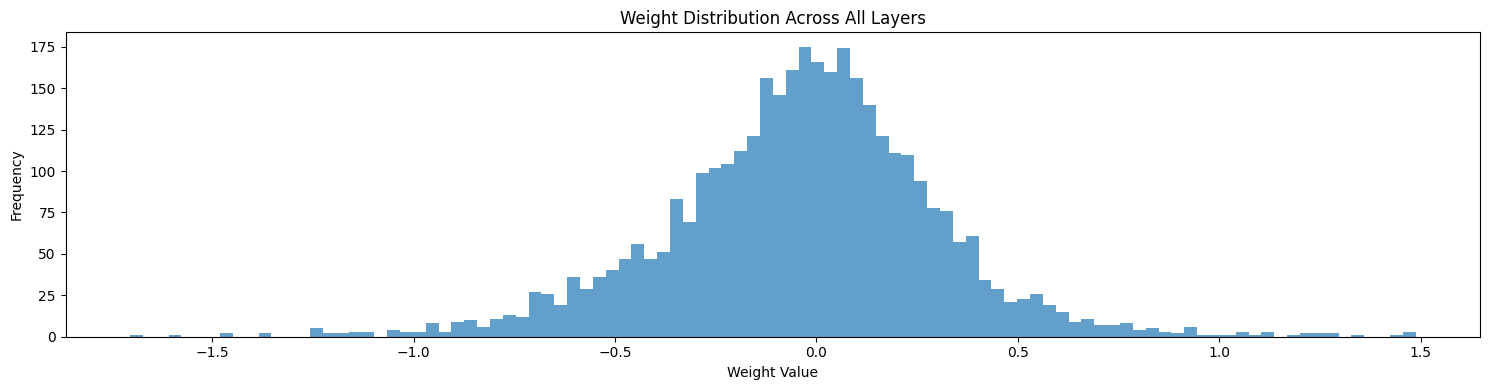

In [34]:
def visualize_weights(model: torch.nn.Module, 
                     plot_type: str = "histogram", 
                     max_neurons: int = 1000) -> None:
    """
    Visualize weights of any PyTorch model dynamically.
    
    Args:
        model: Trained PyTorch model.
        plot_type: "histogram", "heatmap", or "first_layer".
        max_neurons: Downsample large layers for clearer visualization.
    """
    weights: Dict[str, torch.Tensor] = {}
    
    # Extract all linear layer weights
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            weights[name] = layer.weight.detach().cpu()
    
    if not weights:
        print("No linear layers found in the model!")
        return

    # --- Plotting ---
    plt.figure(figsize=(15, 4))
    
    if plot_type == "histogram":
        # Histogram of all weights
        all_weights = torch.cat([w.flatten() for w in weights.values()])
        plt.hist(all_weights.numpy(), bins=100, alpha=0.7)
        plt.title("Weight Distribution Across All Layers")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
    
    elif plot_type == "heatmap":
        # Heatmap for each layer (downsample if too large)
        n_layers = len(weights)
        fig, axes = plt.subplots(1, n_layers, figsize=(5*n_layers, 4))
        
        for (name, w), ax in zip(weights.items(), axes):
            w_np = w.numpy()
            if w.shape[0] > max_neurons or w.shape[1] > max_neurons:
                w_np = w_np[:max_neurons, :max_neurons]
            im = ax.imshow(w_np, cmap='coolwarm', aspect='auto')
            ax.set_title(f"{name}\n{w.shape}")
            plt.colorbar(im, ax=ax)
    
    elif plot_type == "first_layer":
        # First layer visualization (assumes image input if dim matches)
        first_layer = next(iter(weights.values()))
        if first_layer.shape[1] in [784, 3072]:  # Common image sizes (28x28, 32x32x3)
            dim = int(np.sqrt(first_layer.shape[1])) if first_layer.shape[1] == 784 else 32
            channels = 1 if first_layer.shape[1] == 784 else 3
            
            filters = first_layer.view(-1, channels, dim, dim)
            filters = filters.permute(0, 2, 3, 1)  # [filters, H, W, C]
            
            n_filters = min(16, filters.shape[0])
            fig, axes = plt.subplots(1, n_filters, figsize=(15, 3))
            
            for i in range(n_filters):
                if n_filters == 1:
                    axes.imshow(filters[i].squeeze(), cmap='gray')
                else:
                    axes[i].imshow(filters[i].squeeze(), cmap='gray')
                    axes[i].axis('off')
            plt.suptitle("First Layer Filters", y=1.05)
    
    plt.tight_layout()
    plt.show()

# Usage Example
visualize_weights(model, plot_type="histogram")  # or "heatmap"/"first_layer"

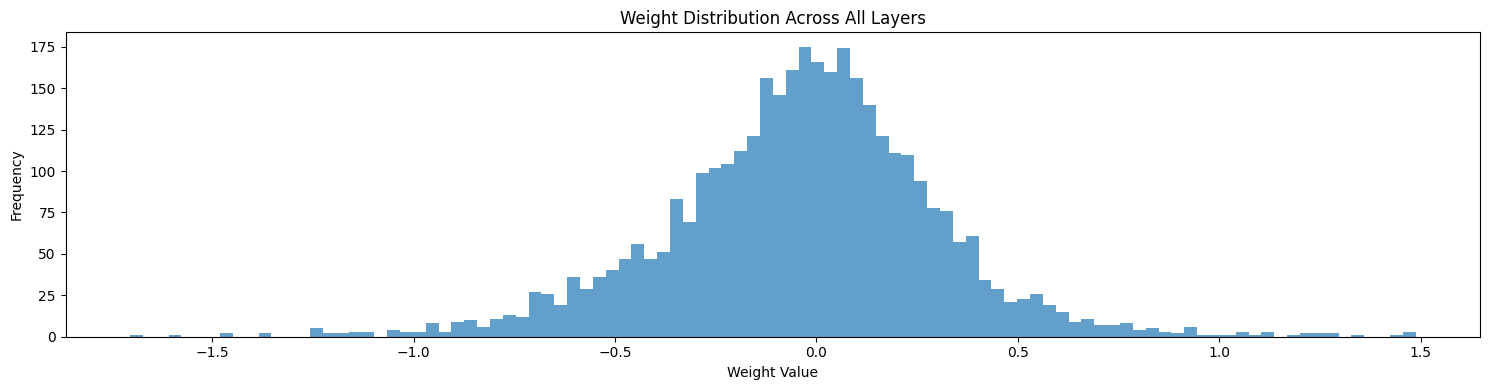

In [35]:
visualize_weights(model, plot_type="histogram")  # or "heatmap"/"first_layer"

<Figure size 1500x400 with 0 Axes>

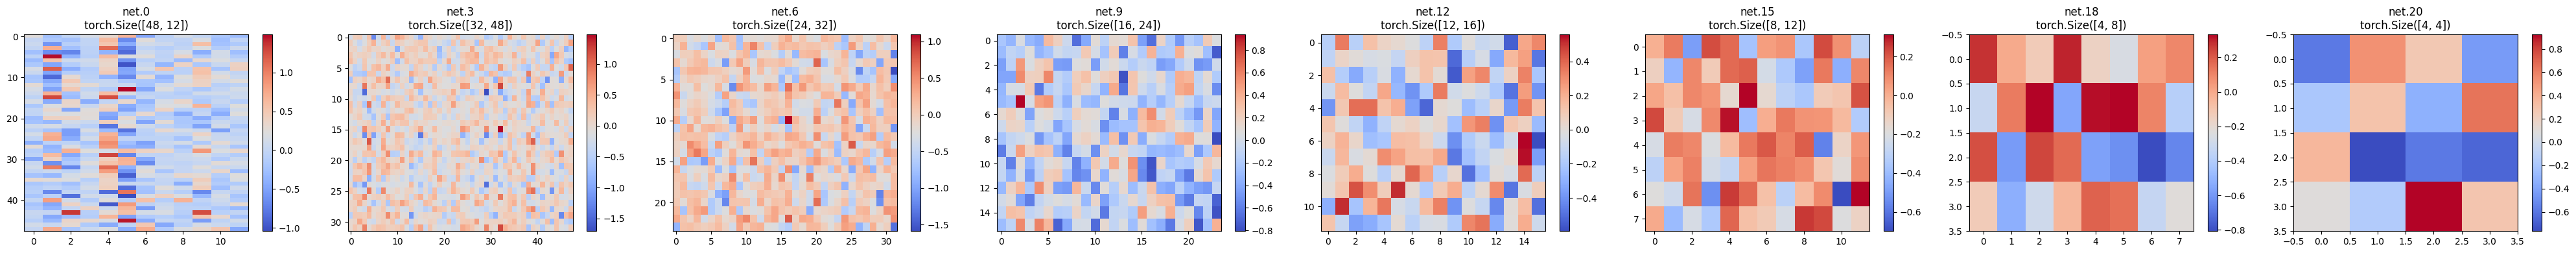

In [36]:
visualize_weights(model, "heatmap")

In [37]:
visualize_weights(model, "first_layer")

<Figure size 1500x400 with 0 Axes>

In [38]:
# Get all weights as a dictionary
weights = {name: layer.weight.detach().cpu() 
           for name, layer in model.named_modules() 
           if isinstance(layer, torch.nn.Linear)}

# Print layer stats
for name, w in weights.items():
    print(f"{name}: shape={w.shape} | mean={w.mean():.4f} | std={w.std():.4f}")

net.0: shape=torch.Size([48, 12]) | mean=0.0283 | std=0.3745
net.3: shape=torch.Size([32, 48]) | mean=-0.0215 | std=0.3366
net.6: shape=torch.Size([24, 32]) | mean=-0.0977 | std=0.3521
net.9: shape=torch.Size([16, 24]) | mean=-0.0765 | std=0.3038
net.12: shape=torch.Size([12, 16]) | mean=-0.0217 | std=0.2443
net.15: shape=torch.Size([8, 12]) | mean=-0.0569 | std=0.2290
net.18: shape=torch.Size([4, 8]) | mean=-0.1160 | std=0.3419
net.20: shape=torch.Size([4, 4]) | mean=-0.0213 | std=0.5161


# 9. Implemente validação cruzada para avaliar melhor o desempenho do modelo

In [42]:
def cross_validate(
    X, y, 
    input_size, 
    hidden_sizes, 
    output_size,
    n_splits=5,
    learning_rate=0.001,
    batch_size=32,
    num_epochs=100,
    act_fun=nn.ReLU(),
    dropout_rate=0,
    patience=5,
    random_state=42
):
    """
    Perform k-fold cross-validation.
    
    Returns:
    - Tuple of (mean_accuracy, std_accuracy, all_accuracies)
    """
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    accuracies = []
    
    for outer_fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(X)):
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]
        X_test = torch.FloatTensor(X_test)
        y_test = torch.LongTensor(y_test)
    
        # Inner loop for hyperparameter tuning/early stopping
        for inner_fold, (train_idx, val_idx) in enumerate(inner_cv.split(X_train_val)):
            
            # Split data
            X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
            
            # Convert to tensors
            X_train_tensor = torch.FloatTensor(X_train)
            y_train_tensor = torch.LongTensor(y_train)
            X_val_tensor = torch.FloatTensor(X_val)
            y_val_tensor = torch.LongTensor(y_val)
            
            # Train model
            model, _, _ = train_model(
                x_train=X_train_tensor,
                y_train=y_train_tensor,
                x_val=X_val_tensor,
                y_val=y_val_tensor,
                input_size=input_size,
                hidden_sizes=hidden_sizes,
                output_size=output_size,
                learning_rate=learning_rate,
                batch_size=batch_size,
                num_epochs=num_epochs,
                act_fun=act_fun,
                dropout_rate=dropout_rate,
                patience=patience,
                verbose=False
            )
        
        # Evaluate on outer test fold
        _, acc = evaluate_model(model, X_test, y_test)
        accuracies.append(acc)
    
    print(f"True unbiased accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")

    return np.mean(accuracies), np.std(accuracies), accuracies

# Usage Example
mean_acc, std_acc, fold_accs = cross_validate(
    X=X,
    y=y,
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    n_splits=5,
    learning_rate=0.001
)

print(f"\nFinal CV Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")
print("Per-fold accuracies:", [f"{a:.3f}" for a in fold_accs])


Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5
True unbiased accuracy: 0.838 ± 0.014

Final CV Accuracy: 0.838 ± 0.014
Per-fold accuracies: ['0.812', '0.833', '0.848', '0.845', '0.850']


# 10. Salve e carregue o modelo treinado usando torch.save() e torch.load()

In [ ]:
model = load_model('model.pth')

# 11. Otimize o modelo usando o Optuna

In [43]:
import optuna

In [44]:
def objective(trial):
    # Number of layers and neurons in each layer
    hs = [0, 8, 16, 32, 64]
    hidden_sizes = []
    for i in range(4):
        hsi = trial.suggest_int(f'hs{i}', 0, 4)
        if hsi != 0:
            hidden_sizes.append(hs[hsi])

    # Dropout rate
    dropout_rate = trial.suggest_float('dropout', 0, 0.5)
    
    # Activation functions
    act_fun_list = [
        nn.ReLU(),
        nn.LeakyReLU(),
        nn.GELU(),
        nn.ELU(),
        nn.Sigmoid(),
        nn.Tanh(),
        ]
    act_fun = act_fun_list[trial.suggest_int('act_fun', 0, 5)]
    
    # Batch size
    batch_size = trial.suggest_int('batch_size', 1, 8)*8
    
    # Learning rate
    learning_rate = trial.suggest_float('lr', 0.0005, 0.01)

    cv_mean, _, _, = cross_validate(
    X, y,
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    n_splits=5,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=100,
    act_fun=act_fun,
    dropout_rate=dropout_rate,
    patience=5,
    random_state=42
    )

    return cv_mean

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params

[I 2025-04-25 13:13:24,036] A new study created in memory with name: no-name-12fdf454-8552-409e-b8e3-b36577344a6b



Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5


[I 2025-04-25 13:14:41,052] Trial 0 finished with value: 0.7529999999999999 and parameters: {'hs0': 1, 'hs1': 2, 'hs2': 2, 'hs3': 4, 'dropout': 0.4116719862307024, 'act_fun': 3, 'batch_size': 4, 'lr': 0.0024237497912406774}. Best is trial 0 with value: 0.7529999999999999.


True unbiased accuracy: 0.753 ± 0.024

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5


[I 2025-04-25 13:15:51,042] Trial 1 finished with value: 0.8774999999999998 and parameters: {'hs0': 3, 'hs1': 0, 'hs2': 1, 'hs3': 0, 'dropout': 0.2839554368388161, 'act_fun': 3, 'batch_size': 4, 'lr': 0.004576616336235751}. Best is trial 0 with value: 0.7529999999999999.


True unbiased accuracy: 0.877 ± 0.016

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5

Fold 3/5

Fold 1/5

Fold 2/5
